<a href="https://colab.research.google.com/github/MehtapAgir/ML_Eng/blob/main/IVF_Revisions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IVF ensemble with engineered features
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install xgboost lightgbm shap openpyxl


In [3]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


In [6]:
data = pd.read_excel('/content/drive/MyDrive/ivf/raw_data.xlsx')


In [7]:
drop_cols = ['ID', 'Toxoplasma gondii IgM', 'Cytomegalovirus IgM', 'Rubella virus IgM', 'Herpes simplex virus IgM',
             'Chlamydia Infections', 'gonorrhea', 'Fungal vaginosis', 'Trichomonal vaginosis', 'Cycle type',
             'Chromosome abnormality', 'Infertility type', 'Male sperm abnormality', 'Abnormal ovarian structure',
             'Abnormal uterine structure', 'History of uterine cavity surgery', 'ABO blood group',
             'Rh blood group', 'Cleaning degree of vagina', 'Endometrial type in implant date']

data.drop(columns=drop_cols, inplace=True, errors='ignore')
data = data[data.isnull().sum(axis=1) <= len(data.columns) * 0.5]

num_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = data.select_dtypes(include=['object']).columns.tolist()

for col in num_cols:
    data[col].fillna(data[col].median(), inplace=True)
for col in cat_cols:
    data[col].fillna(data[col].mode()[0], inplace=True)
    data[col] = LabelEncoder().fit_transform(data[col].astype(str))

# Feature engineering
if 'FSH' in data.columns and 'LH' in data.columns:
    data['FSH_LH_ratio'] = data['FSH'] / (data['LH'] + 1e-3)
if 'AMH' in data.columns and 'Female age' in data.columns:
    data['AMH_Age'] = data['AMH'] * data['Female age']
if 'Endometrial thickness in transfer date' in data.columns and 'Quality of implanted embryos' in data.columns:
    data['Endometrial_Quality'] = data['Endometrial thickness in transfer date'] * data['Quality of implanted embryos']

# Normalize numerical
scaler = MinMaxScaler()
data[num_cols] = scaler.fit_transform(data[num_cols])


<ipython-input-7-46df851c8c16>:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


In [8]:
X = data.drop(columns=['Pregnancy outcome'])
y = data['Pregnancy outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(n_estimators=100, max_depth=4, learning_rate=0.1,
                    subsample=0.8, colsample_bytree=0.6, gamma=0.1,
                    scale_pos_weight=scale_pos_weight,
                    use_label_encoder=False, eval_metric='logloss')

ensemble = VotingClassifier(estimators=[
    ('xgb', xgb),
    ('lgb', LGBMClassifier()),
    ('lr', LogisticRegression(max_iter=1000))
], voting='soft', n_jobs=-1)

ensemble.fit(X_train, y_train)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.6, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning...bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lgb', LGBMClassifier()),
                             ('lr', LogisticRegression(max_iter=1000))],
                 n_jobs=-1, voting='soft')

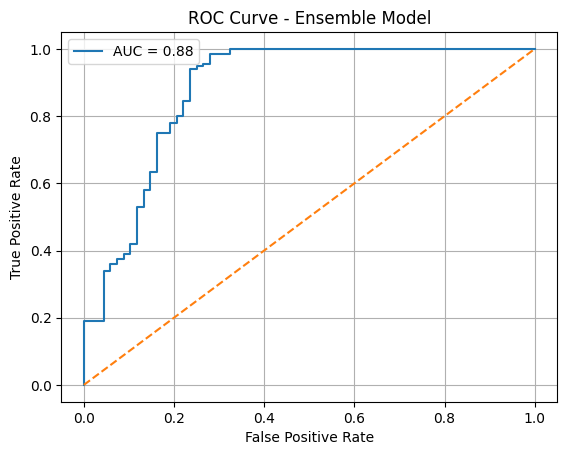

In [9]:
y_scores = ensemble.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_scores):.2f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend()
plt.grid(True)
plt.show()


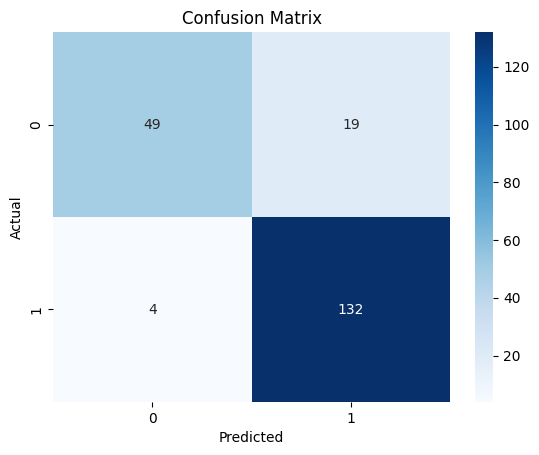

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = (y_scores >= 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


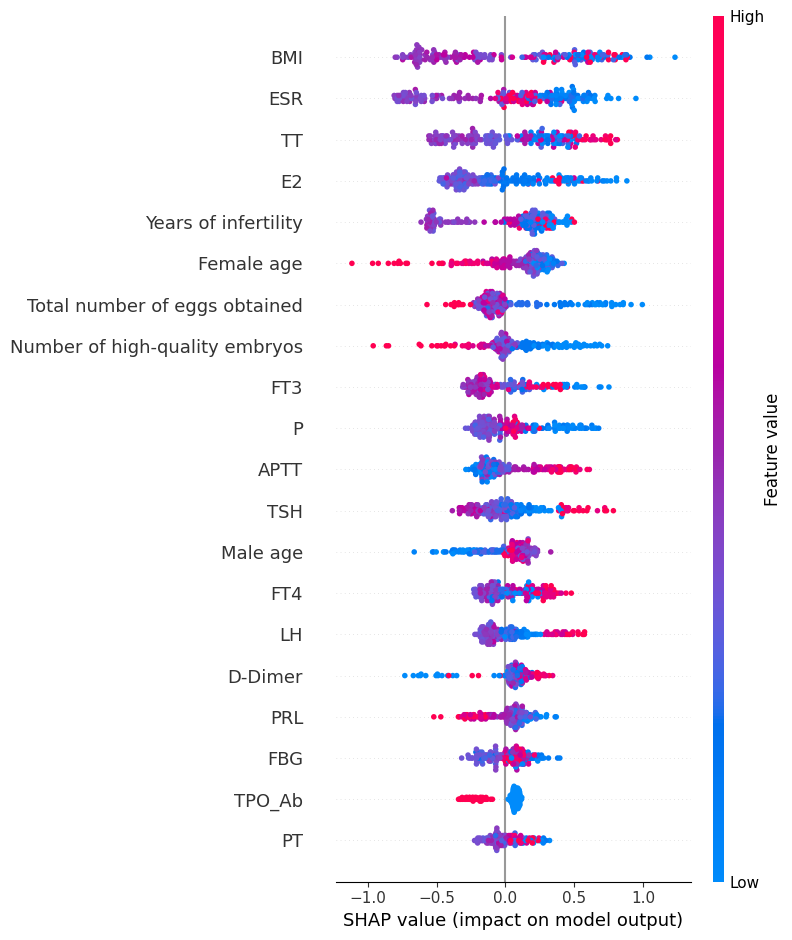

In [13]:
shap.summary_plot(shap_values, X_test)


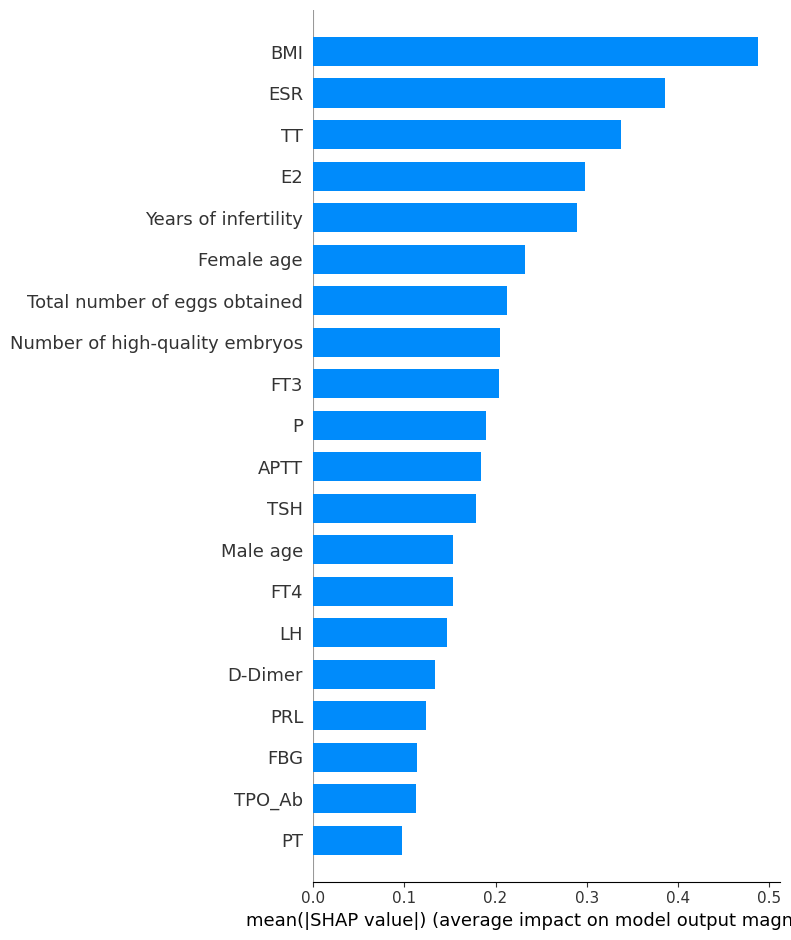

In [14]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


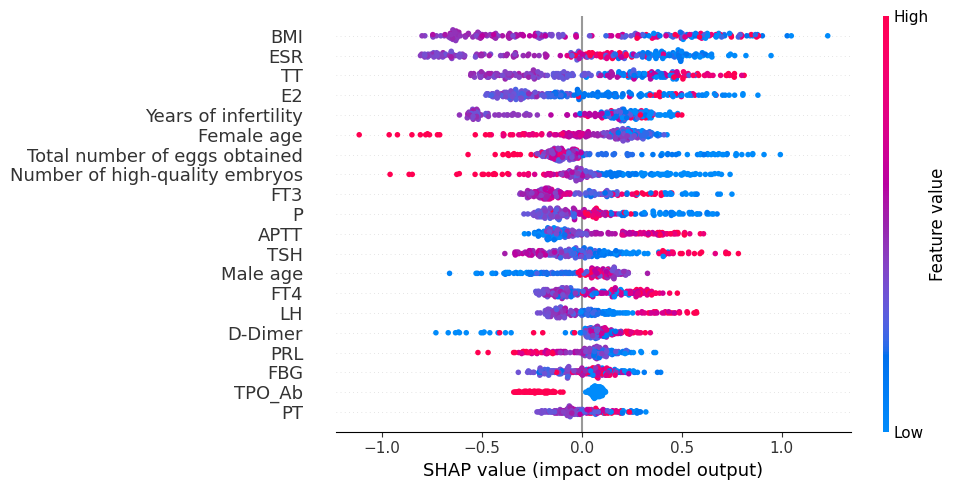

In [15]:
shap.summary_plot(shap_values, X_test, plot_size=(10, 5))


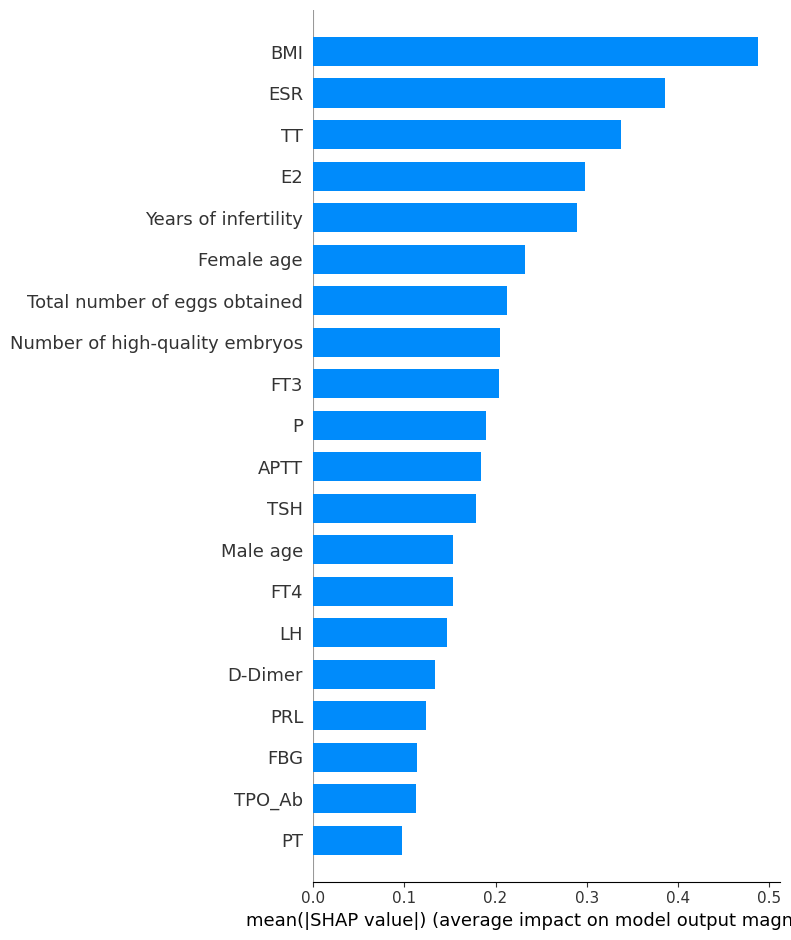

In [16]:
shap.summary_plot(shap_values, X_test, plot_type="bar")


In [18]:
print([col for col in X_train.columns if 'AMH' in col or 'FSH' in col or 'Endometrial' in col])


['FSH', 'AMH', 'Endometrial thickness in transfer date', 'FSH_LH_ratio', 'AMH_Age', 'Endometrial_Quality']


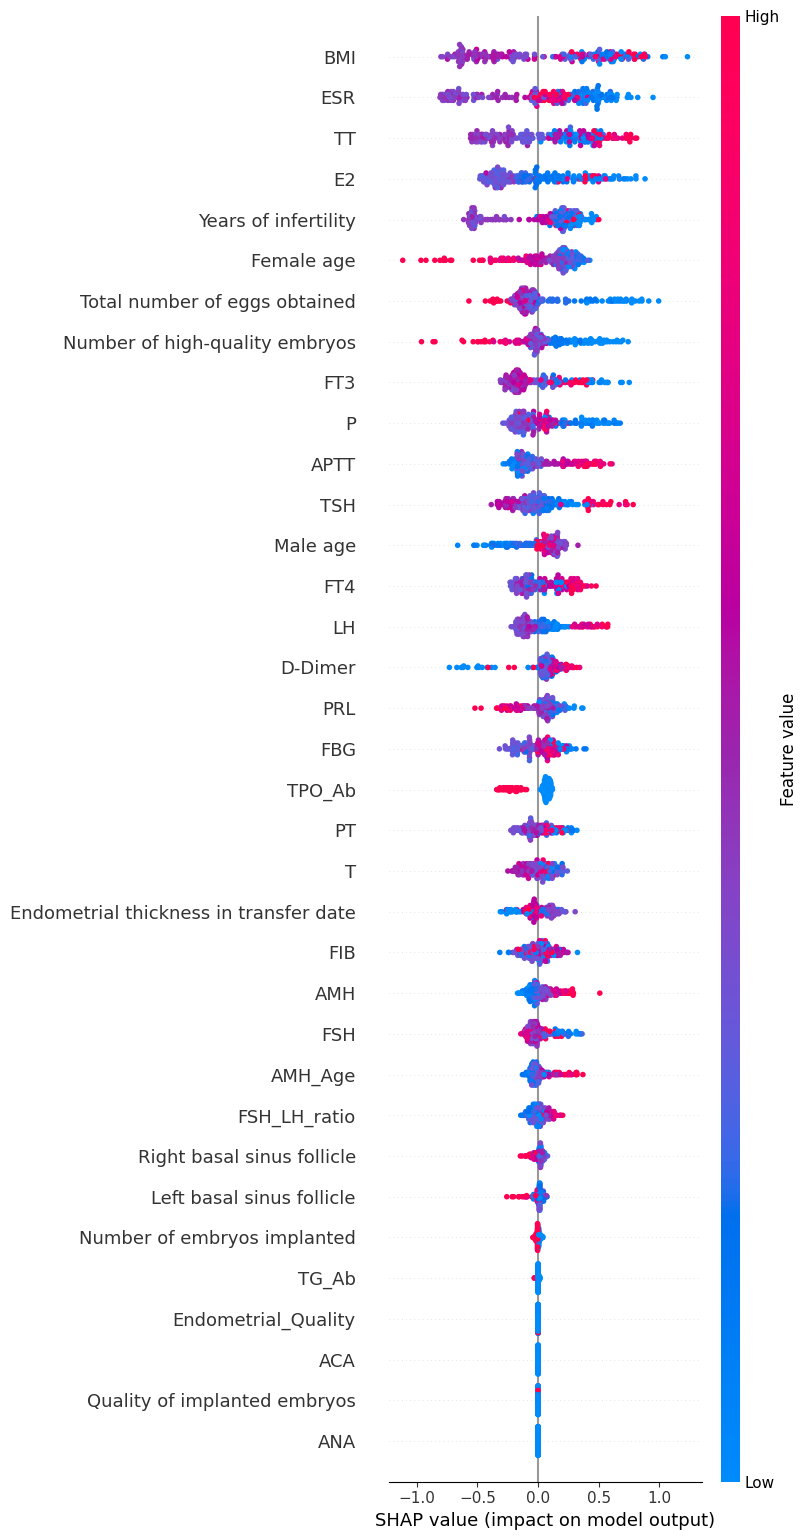

In [19]:
shap.summary_plot(shap_values, X_test, max_display=50)
